# SketchRNN Project

### by

### Daniyal Mufti

In [31]:
import sys
assert sys.version_info >= (3,5)

import tensorflow as tf
from tensorflow import keras
assert tf.__version__ >= "2.0"

if not tf.config.list_physical_devices('GPU'):
    print("No GPU was detected. LSTMs and CNNs can be very slow without a GPU.")
    if IS_COLAB:
        print("Go to Runtime > Change runtime and select a GPU hardware accelerator.")
    if IS_KAGGLE:
        print("Go to Settings > Accelerator and select GPU.")
else:
    print("GPU Activated")
    
import numpy as np
import os
from pathlib import Path
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt

GPU Activated


In [32]:
DOWNLOAD_ROOT = "http://download.tensorflow.org/data/"
FILENAME = "quickdraw_tutorial_dataset_v1.tar.gz"
filepath = keras.utils.get_file(FILENAME,
                                DOWNLOAD_ROOT + FILENAME,
                                cache_subdir="C:\\Users\\Daniy\\2023 Machine Learning Projects\\SketchRNN_Dataset",
                                extract=True)

1065301781/1065301781 [==============================] - 31s 0us/step


In [33]:
quickdraw_dir = Path(filepath).parent
train_files = [str(path) for path in quickdraw_dir.glob("training.tfrecord-*")]
eval_files = [str(path) for path in quickdraw_dir.glob("eval.tfrecord-*")]

In [34]:
train_files

['C:\\Users\\Daniy\\2023 Machine Learning Projects\\SketchRNN_Dataset\\training.tfrecord-00000-of-00010',
 'C:\\Users\\Daniy\\2023 Machine Learning Projects\\SketchRNN_Dataset\\training.tfrecord-00001-of-00010',
 'C:\\Users\\Daniy\\2023 Machine Learning Projects\\SketchRNN_Dataset\\training.tfrecord-00002-of-00010',
 'C:\\Users\\Daniy\\2023 Machine Learning Projects\\SketchRNN_Dataset\\training.tfrecord-00003-of-00010',
 'C:\\Users\\Daniy\\2023 Machine Learning Projects\\SketchRNN_Dataset\\training.tfrecord-00004-of-00010',
 'C:\\Users\\Daniy\\2023 Machine Learning Projects\\SketchRNN_Dataset\\training.tfrecord-00005-of-00010',
 'C:\\Users\\Daniy\\2023 Machine Learning Projects\\SketchRNN_Dataset\\training.tfrecord-00006-of-00010',
 'C:\\Users\\Daniy\\2023 Machine Learning Projects\\SketchRNN_Dataset\\training.tfrecord-00007-of-00010',
 'C:\\Users\\Daniy\\2023 Machine Learning Projects\\SketchRNN_Dataset\\training.tfrecord-00008-of-00010',
 'C:\\Users\\Daniy\\2023 Machine Learning Proj

In [35]:
eval_files

['C:\\Users\\Daniy\\2023 Machine Learning Projects\\SketchRNN_Dataset\\eval.tfrecord-00000-of-00010',
 'C:\\Users\\Daniy\\2023 Machine Learning Projects\\SketchRNN_Dataset\\eval.tfrecord-00001-of-00010',
 'C:\\Users\\Daniy\\2023 Machine Learning Projects\\SketchRNN_Dataset\\eval.tfrecord-00002-of-00010',
 'C:\\Users\\Daniy\\2023 Machine Learning Projects\\SketchRNN_Dataset\\eval.tfrecord-00003-of-00010',
 'C:\\Users\\Daniy\\2023 Machine Learning Projects\\SketchRNN_Dataset\\eval.tfrecord-00004-of-00010',
 'C:\\Users\\Daniy\\2023 Machine Learning Projects\\SketchRNN_Dataset\\eval.tfrecord-00005-of-00010',
 'C:\\Users\\Daniy\\2023 Machine Learning Projects\\SketchRNN_Dataset\\eval.tfrecord-00006-of-00010',
 'C:\\Users\\Daniy\\2023 Machine Learning Projects\\SketchRNN_Dataset\\eval.tfrecord-00007-of-00010',
 'C:\\Users\\Daniy\\2023 Machine Learning Projects\\SketchRNN_Dataset\\eval.tfrecord-00008-of-00010',
 'C:\\Users\\Daniy\\2023 Machine Learning Projects\\SketchRNN_Dataset\\eval.tfreco

In [36]:
with open(quickdraw_dir / "eval.tfrecord.classes") as test_classes_file:
    test_classes = test_classes_file.readlines()
    
with open(quickdraw_dir / "training.tfrecord.classes") as train_classes_file:
    train_classes = train_classes_file.readlines() 
    
print(test_classes == train_classes)  
print(type(test_classes))

True
<class 'list'>


In [37]:
assert train_classes == test_classes
class_names = [name.strip().lower() for name in train_classes]

In [38]:
print(sorted(class_names))

['aircraft carrier', 'airplane', 'alarm clock', 'ambulance', 'angel', 'animal migration', 'ant', 'anvil', 'apple', 'arm', 'asparagus', 'axe', 'backpack', 'banana', 'bandage', 'barn', 'baseball', 'baseball bat', 'basket', 'basketball', 'bat', 'bathtub', 'beach', 'bear', 'beard', 'bed', 'bee', 'belt', 'bench', 'bicycle', 'binoculars', 'bird', 'birthday cake', 'blackberry', 'blueberry', 'book', 'boomerang', 'bottlecap', 'bowtie', 'bracelet', 'brain', 'bread', 'bridge', 'broccoli', 'broom', 'bucket', 'bulldozer', 'bus', 'bush', 'butterfly', 'cactus', 'cake', 'calculator', 'calendar', 'camel', 'camera', 'camouflage', 'campfire', 'candle', 'cannon', 'canoe', 'car', 'carrot', 'castle', 'cat', 'ceiling fan', 'cell phone', 'cello', 'chair', 'chandelier', 'church', 'circle', 'clarinet', 'clock', 'cloud', 'coffee cup', 'compass', 'computer', 'cookie', 'cooler', 'couch', 'cow', 'crab', 'crayon', 'crocodile', 'crown', 'cruise ship', 'cup', 'diamond', 'dishwasher', 'diving board', 'dog', 'dolphin', 

In [39]:
def parse(data_batch):
    feature_descriptions = {
        "ink" : tf.io.VarLenFeature(dtype=tf.float32),
        "shape": tf.io.FixedLenFeature([2], dtype=tf.int64),
        "class_index": tf.io.FixedLenFeature([1], dtype=tf.int64)
    }
    examples = tf.io.parse_example(data_batch, feature_descriptions)
    flat_sketches = tf.sparse.to_dense(examples["ink"])
    sketches = tf.reshape(flat_sketches, shape=[tf.size(data_batch), -1, 3])
    lengths = examples["shape"][:, 0]
    labels = examples["class_index"][:, 0]
    return sketches, lengths, labels    

In [40]:
def quickdraw_dataset(filepaths, batch_size=32, shuffle_buffer_size=None,
                     n_parse_threads=5, n_read_threads=5, cache=False):
    dataset = tf.data.TFRecordDataset(filepaths, 
                                     num_parallel_reads=n_read_threads)
    if cache:
        dataset = dataset.cache()
    if shuffle_buffer_size:
        dataset = dataset.shuffle(shuffle_buffer_size)
    dataset = dataset.batch(batch_size)  
    dataset = dataset.map(parse, num_parallel_calls=n_parse_threads)
    return dataset.prefetch(1)

In [41]:
train_set = quickdraw_dataset(train_files, shuffle_buffer_size = 10000)
valid_set = quickdraw_dataset(eval_files[:5])
test_set = quickdraw_dataset(eval_files[5:])

In [42]:
for sketches, lengths, labels in train_set.take(1):
    print("Sketches =", sketches)
    print("lengths =", lengths)
    print("labels =", labels)

Sketches = tf.Tensor(
[[[ 0.          0.25581396  0.        ]
  [ 0.01581028  0.06976748  0.        ]
  [ 0.02766798  0.02325577  0.        ]
  ...
  [ 0.          0.          0.        ]
  [ 0.          0.          0.        ]
  [ 0.          0.          0.        ]]

 [[ 0.01704544  0.05118114  0.        ]
  [ 0.11931819  0.11417323  0.        ]
  [ 0.05113637  0.02755904  0.        ]
  ...
  [ 0.          0.          0.        ]
  [ 0.          0.          0.        ]
  [ 0.          0.          0.        ]]

 [[ 0.          0.08878504  0.        ]
  [-0.03529412  0.30373833  0.        ]
  [-0.00784314  0.24299067  0.        ]
  ...
  [ 0.          0.          0.        ]
  [ 0.          0.          0.        ]
  [ 0.          0.          0.        ]]

 ...

 [[-0.00714286 -0.18039218  0.        ]
  [ 0.01428571 -0.08235294  0.        ]
  [ 0.02857143 -0.02352941  0.        ]
  ...
  [ 0.          0.          0.        ]
  [ 0.          0.          0.        ]
  [ 0.          0.    

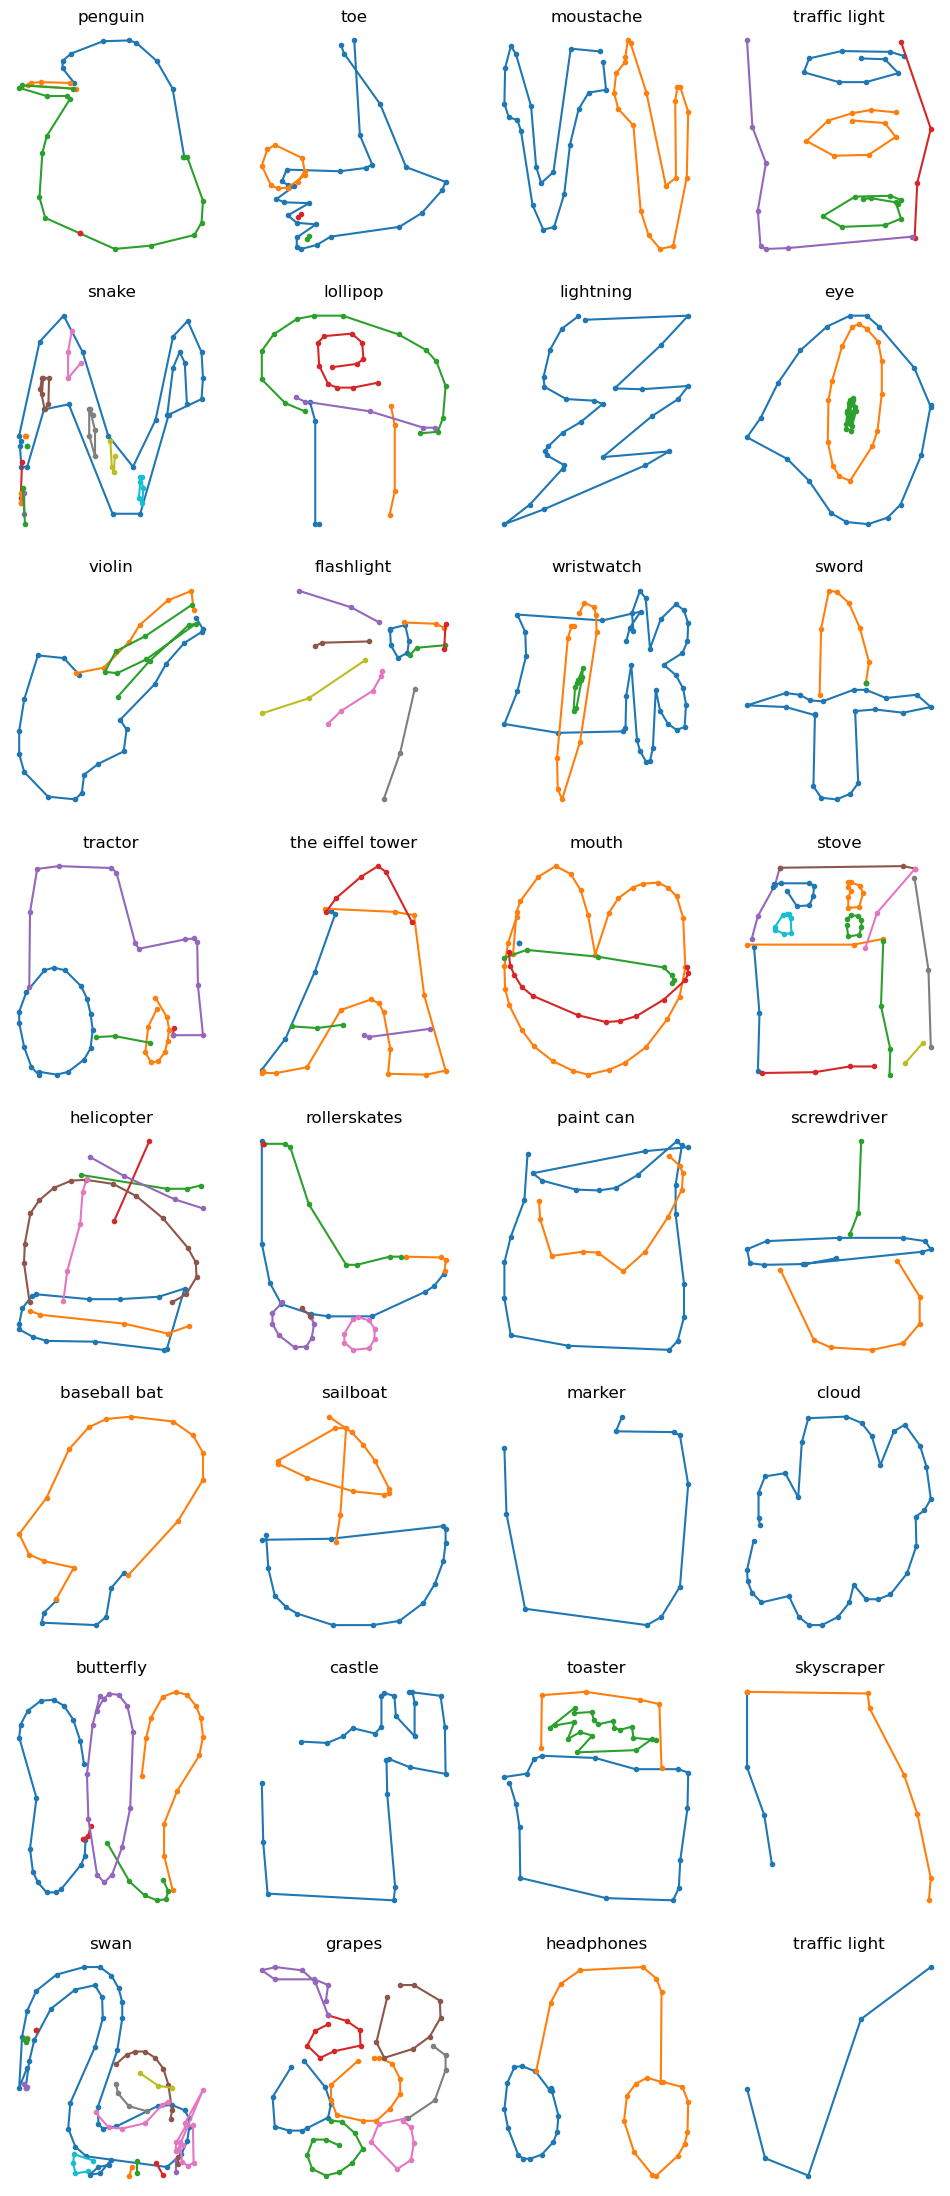

In [45]:
def draw_sketch(sketch, label=None):
    origin = np.array([[0.,0.,0.]])
    sketch = np.r_[origin, sketch]
    stroke_end_indices = np.argwhere(sketch[:, -1]==1.)[:, 0]
    coordinates = np.cumsum(sketch[:, :2], axis=0)
    strokes = np.split(coordinates, stroke_end_indices + 1)
    title = class_names[label.numpy()] if label is not None else "Try to Guess"
    plt.title(title)
    #plt.plot(coordinates[:, 0], -coordinates[:,1], "y:")
    for stroke in strokes:
        plt.plot(stroke[:,0], -stroke[:,1], ".-")
    plt.axis("off")    
        
def draw_sketches(sketches, lengths, labels):
    n_sketches = len(sketches)
    n_cols = 4
    n_rows = (n_sketches - 1) // n_cols + 1
    plt.figure(figsize=(n_cols*3,n_rows*3.5))
    for index, sketch, length, label in zip(range(n_sketches), sketches, lengths, labels):
        plt.subplot(n_rows, n_cols, index+1)
        draw_sketch(sketch[:length], label)
    plt.show()
    
for sketches, lengths, labels in train_set.take(1):
    draw_sketches(sketches, lengths, labels)
    

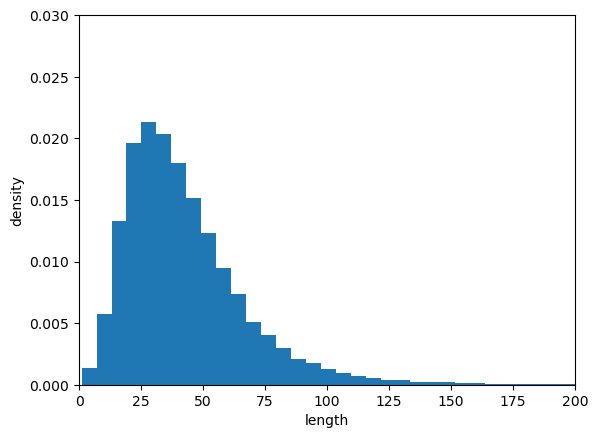

In [49]:
lengths = np.concatenate([lengths for _,lengths,_ in train_set.take(1000)])
plt.hist(lengths, bins=150, density=True)
plt.axis([0,200,0,0.03])
plt.xlabel("length")
plt.ylabel("density")
plt.show()

In [50]:
def crop_long_sketches(dataset, max_length=100):
    return dataset.map(lambda inks, lengths, labels: (inks[:, :max_length], labels))

cropped_train_set = crop_long_sketches(train_set)
cropped_valid_set = crop_long_sketches(valid_set)
cropped_test_set = crop_long_sketches(test_set)

print(train_set)
print(cropped_train_set)

<PrefetchDataset element_spec=(TensorSpec(shape=(None, None, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>
<MapDataset element_spec=(TensorSpec(shape=(None, None, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>


In [51]:
model = keras.models.Sequential([
    keras.layers.Conv1D(32, kernel_size=5, strides=2, activation="relu"),
    keras.layers.BatchNormalization(),
    keras.layers.Conv1D(64, kernel_size=5, strides=2, activation="relu"),
    keras.layers.BatchNormalization(),
    keras.layers.Conv1D(128, kernel_size=3, strides=2, activation="relu"),
    keras.layers.BatchNormalization(),
    keras.layers.LSTM(128, return_sequences=True),
    keras.layers.LSTM(128),
    keras.layers.Dense(len(class_names), activation="softmax")
])
optimizer = keras.optimizers.SGD(learning_rate=1e-2, clipnorm=1.)
model.compile(loss="sparse_categorical_crossentropy",
              optimizer=optimizer,
              metrics=["accuracy", "sparse_top_k_categorical_accuracy"])
history = model.fit(cropped_train_set, epochs=5,
                    validation_data=cropped_valid_set)
    

Epoch 1/5
107813/107813 [==============================] - 2425s 22ms/step - loss: 4.1105 - accuracy: 0.1648 - sparse_top_k_categorical_accuracy: 0.3672 - val_loss: 3.0360 - val_accuracy: 0.3202 - val_sparse_top_k_categorical_accuracy: 0.6046
Epoch 2/5
107813/107813 [==============================] - 2475s 23ms/step - loss: 2.7080 - accuracy: 0.3788 - sparse_top_k_categorical_accuracy: 0.6680 - val_loss: 2.4338 - val_accuracy: 0.4303 - val_sparse_top_k_categorical_accuracy: 0.7194
Epoch 3/5
107813/107813 [==============================] - 2416s 22ms/step - loss: 2.3151 - accuracy: 0.4537 - sparse_top_k_categorical_accuracy: 0.7401 - val_loss: 2.1909 - val_accuracy: 0.4771 - val_sparse_top_k_categorical_accuracy: 0.7616
Epoch 4/5
107813/107813 [==============================] - 2587s 24ms/step - loss: 2.1120 - accuracy: 0.4946 - sparse_top_k_categorical_accuracy: 0.7744 - val_loss: 2.0292 - val_accuracy: 0.5124 - val_sparse_top_k_categorical_accuracy: 0.7875
Epoch 5/5
107813/107813 [===

In [52]:
y_test = np.concatenate([labels for _, _, labels in test_set])
y_probas = model.predict(test_set)

5392/5392 [==============================] - 31s 5ms/step


In [53]:
np.mean(keras.metrics.sparse_top_k_categorical_accuracy(y_test, y_probas))

0.6904386

In [66]:
for sketches2, lengths, labels in test_set.take(1):
    print("Sketches =", sketches2)

Sketches = tf.Tensor(
[[[-0.05882353 -0.0047619   0.        ]
  [-0.07843138  0.02857143  0.        ]
  [-0.07450981  0.03809525  0.        ]
  ...
  [ 0.          0.          0.        ]
  [ 0.          0.          0.        ]
  [ 0.          0.          0.        ]]

 [[ 0.01568628 -0.05737704  0.        ]
  [ 0.29411766 -0.46721312  0.        ]
  [ 0.12941176 -0.1147541   0.        ]
  ...
  [ 0.          0.          0.        ]
  [ 0.          0.          0.        ]
  [ 0.          0.          0.        ]]

 [[ 0.34509805 -0.16513762  0.        ]
  [ 0.12549022  0.00917431  0.        ]
  [ 0.04705882  0.1651376   0.        ]
  ...
  [ 0.          0.          0.        ]
  [ 0.          0.          0.        ]
  [ 0.          0.          0.        ]]

 ...

 [[ 0.         -0.15909094  0.        ]
  [ 0.03137255 -0.13068181  0.        ]
  [ 0.         -0.06818181  0.        ]
  ...
  [ 0.          0.          0.        ]
  [ 0.          0.          0.        ]
  [ 0.          0.    

1/1 [==============================] - 0s 25ms/step


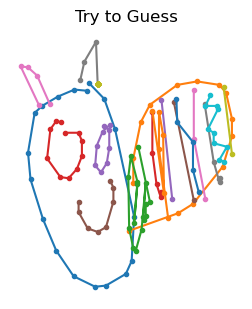

Top-5 predictions:
  1. bee 12.768%
  2. tiger 8.896%
  3. blueberry 8.521%
  4. onion 5.501%
  5. dog 3.957%
Answer: raccoon


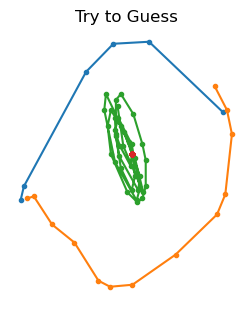

Top-5 predictions:
  1. garden hose 31.644%
  2. eye 15.829%
  3. moustache 4.865%
  4. mouse 4.042%
  5. pond 3.878%
Answer: eye


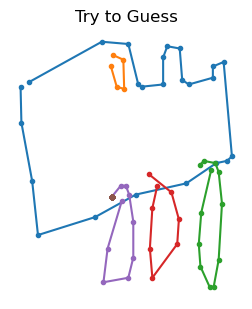

Top-5 predictions:
  1. submarine 49.468%
  2. skateboard 4.062%
  3. pickup truck 3.628%
  4. bat 3.470%
  5. key 3.224%
Answer: train


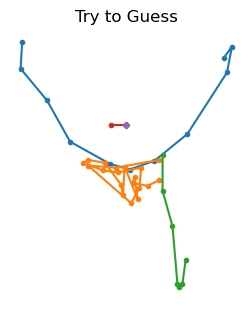

Top-5 predictions:
  1. goatee 42.377%
  2. stethoscope 15.478%
  3. necklace 12.101%
  4. beard 4.425%
  5. toe 4.345%
Answer: goatee


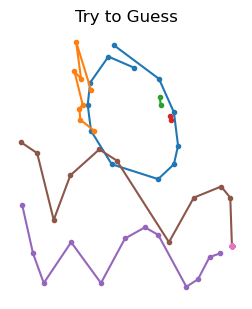

Top-5 predictions:
  1. snake 47.688%
  2. ocean 6.621%
  3. moustache 6.029%
  4. mouse 5.363%
  5. river 4.805%
Answer: whale


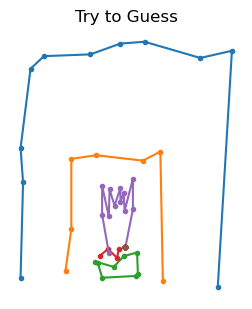

Top-5 predictions:
  1. hospital 55.478%
  2. fireplace 37.881%
  3. door 1.088%
  4. house 0.706%
  5. swing set 0.610%
Answer: fireplace


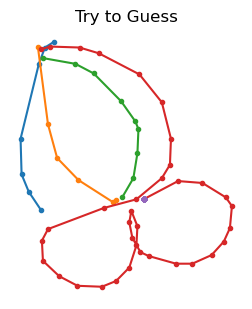

Top-5 predictions:
  1. squiggle 26.745%
  2. nose 21.927%
  3. chandelier 6.959%
  4. garden hose 6.686%
  5. pliers 4.488%
Answer: pliers


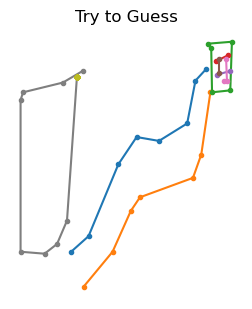

Top-5 predictions:
  1. snake 23.786%
  2. garden hose 20.598%
  3. toothbrush 7.876%
  4. the great wall of china 6.596%
  5. fork 6.144%
Answer: the great wall of china


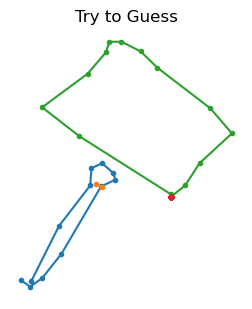

Top-5 predictions:
  1. screwdriver 39.869%
  2. shovel 25.068%
  3. knife 7.176%
  4. spoon 2.180%
  5. sword 1.554%
Answer: matches


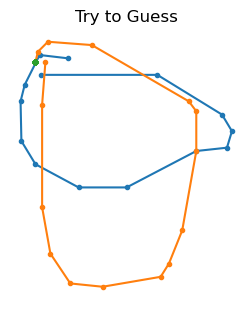

Top-5 predictions:
  1. pool 16.740%
  2. canoe 16.673%
  3. hot tub 8.795%
  4. paper clip 6.100%
  5. bathtub 3.839%
Answer: hot dog


In [67]:
n_new = 10
Y_probas = model.predict(sketches2)
top_k = tf.nn.top_k(Y_probas, k=5)
for index in range(n_new):
    plt.figure(figsize=(3, 3.5))
    draw_sketch(sketches2[index])
    plt.show()
    print("Top-5 predictions:".format(index + 1))
    for k in range(5):
        class_name = class_names[top_k.indices[index, k]]
        proba = 100 * top_k.values[index, k]
        print("  {}. {} {:.3f}%".format(k + 1, class_name, proba))
    print("Answer: {}".format(class_names[labels[index].numpy()]))

In [68]:
model.save("my_sketchrnn")

INFO:tensorflow:Assets written to: my_sketchrnn\assets


INFO:tensorflow:Assets written to: my_sketchrnn\assets
